# DCT-based Transform Coding of Images

This code is provided as supplementary material of the lecture "Coding of Audiovisual Signals".

This code illustrates
* Transform coding of images using the DCT
* Used for instance in JPEG coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import chain
import scipy.fftpack
import scipy.ndimage
import scipy as sp

from ipywidgets import interactive, HBox, Label
import ipywidgets as widgets

Function to transform a color image to grayscale. Here, we use the method employed in PAL and NTSC and described in ITU-R Rec.601. According to this standard the luma is obtained as \begin{equation} Y^\prime = 0.2989\cdot R + 0.587\cdot G + 0.114\cdot B \end{equation}

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Display and show image. Crop the image also to a mulitple of size 8. Here, we only use black and white images

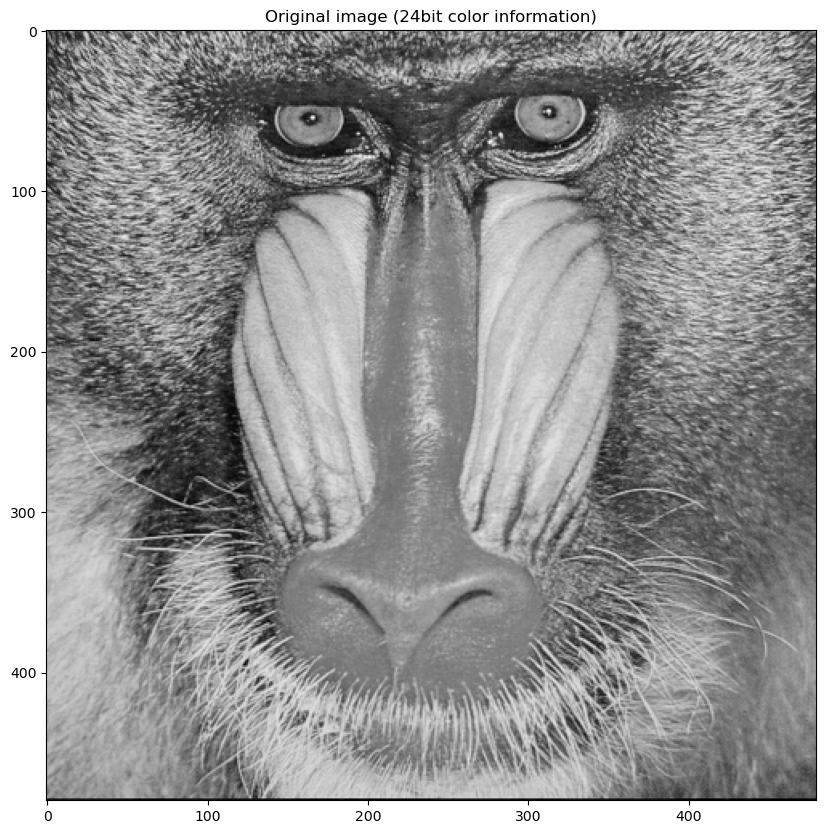

In [3]:
image = rgb2gray( mpimg.imread('Mandrill.png') )

# crop image to be a multiple of 8
image_len0 = int(np.floor(image.shape[0] / 8) * 8)
image_len1 = int(np.floor(image.shape[1] / 8) * 8)

image = image[0:image_len0, 0:image_len1]

plt.figure(1,figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.title('Original image (24bit color information)')
plt.show()

Functions that implement the 2D-DCT and IDCT of type-2 as they are being used in the JPG standard with (see also https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html)
$$
X_{u,v} = f(u)f(v)\sum_{k=0}^{M-1}\sum_{\ell=0}^{M-1}x[k,\ell]\cos\left(\frac{\pi u(2k+1)}{2M}\right)\cos\left(\frac{\pi v(2\ell+1)}{2M}\right)
$$
with
$$
f(x) = \begin{cases}
\sqrt{\frac{1}{M}} & \text{if }k=0 \\
\sqrt{\frac{2}{M}} & \text{otherwise}
\end{cases}
$$
which is, up to a scaling factor, the DCT used in JPG.
Note that the 2D-DCT is decomposable, i.e., we can first execute it on a 2D block in one dimension and then execute the transform in another dimension

In [4]:
def dct2(x):
    return sp.fftpack.dct( sp.fftpack.dct( x, axis=0, norm='ortho' ), axis=1, norm='ortho' )
            
def idct2(x):
    return sp.fftpack.idct( sp.fftpack.idct( x, axis=0 , norm='ortho'), axis=1 , norm='ortho')

Get zig-zag pattern defined in the jpeg standard

In [5]:
def get_zigzag_pattern(n):
    retval = []
    
    for diag in range(n):
        start = [diag,0]
        for i in range(diag+1):
            if diag % 2 == 0:
                retval.append((start[0],start[1]))
            else:
                retval.append((start[1],start[0]))    
            start[0] -= 1
            start[1] += 1

    for diag in reversed(range(n-1)):
        start = [n-1,n-diag-1]
        for i in range(diag+1):
            if diag % 2 == 0:
                retval.append((start[0],start[1]))
            else:
                retval.append((start[1],start[0]))    
            start[0] -= 1
            start[1] += 1
            
    return retval

In [6]:
def show_dct_image(image, num_coeffs, comparison = False):   
    # get zigzag pattern
    zigzag = get_zigzag_pattern(8)
    image_coded = np.zeros_like(image)
    
    for start0 in np.arange(0,image.shape[0], 8):
        for start1 in np.arange(0,image.shape[1], 8):
                        
            # carry out transform
            TC =  dct2(image[start0:(start0+8), start1:(start1+8)]*256 - 128)
            
            # only keep first coefficients in a zig-zag like pattern
            TCz = np.zeros_like(TC)
            for k in range(num_coeffs):
                TCz[zigzag[k][0], zigzag[k][1]] = TC[zigzag[k][0], zigzag[k][1]]
            
            # inverse transform
            image_coded[start0:(start0+8), start1:(start1+8)] = (idct2(TCz) + 128) / 256

    if comparison:
        plt.figure(1,figsize=(16,8))
        plt.subplot(1,2,1)
        plt.imshow(image, cmap='gray')
        plt.title('Original image (monochrome)')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(image_coded, cmap='gray')
        plt.title('Reconstructed image (%d DCT coefficients)' % num_coeffs)
        plt.axis('off')
        plt.show()        
    else:
        plt.figure(1,figsize=(10,10))
        plt.imshow(image_coded, cmap='gray')
        plt.title('Reconstructed image (%d DCT coefficients)' % num_coeffs)
        plt.axis('off')
        plt.show()

In [7]:
interactive_update = interactive(lambda coeffs, compar: show_dct_image(image, coeffs, compar), \
                               coeffs = widgets.IntSlider(min=1,max=64,step=1,value=1, continuous_update=False, description='Coefficients'), \
                               compar = widgets.Checkbox(value=True, description='Compare with original image'))

output = interactive_update.children[-1]
output.layout.height = '650px'
interactive_update

interactive(children=(IntSlider(value=1, continuous_update=False, description='Coefficients', max=64, min=1), …

## Apply DCT to color images

### First step: Transform RGB color into YCbCr color space
In a first step, the RGB color space which denote the colors "red", "blue" and "green", is transformed into a different color space called $\textrm{Y}^\prime \textrm{C}_\textrm{B}\textrm{C}_\textrm{R}$, where Y${}^\prime$ denoes the brightness of a pixel (same as the monochrome value), and the $\textrm{C}_\textrm{B}$ and $\textrm{C}_\textrm{R}$ components represent the chrominance, which is split into a blue and a red component.

The transform between both color spaces can be carried out using a linear transform. 

In [8]:
def RGB2YCbCr(image):
    rgb = image * 255
    retval = np.dot(rgb[...,:3], [[0.299, 0.587, 0.114], [-0.168736, -0.331264, 0.5], [0.5, -0.418688, -0.081312]])
    retval[...,1:3] += 128
    return retval
    
def YCbCr2RGB(image):
    temp = image.copy()
    temp[...,1:3] -= 128
    retval = np.dot(temp[...,:3], [[1, 0, 1.402], [1, -0.344136, -0.714136], [1, 1.772, 0]])
    
    return np.clip(retval / 255, 0, 1)


In [9]:
image_color = mpimg.imread('Mandrill.png')

# crop image to be a multiple of 16
image_len0 = int(np.floor(image_color.shape[0] / 16) * 16)
image_len1 = int(np.floor(image_color.shape[1] / 16) * 16)
image_color = image_color[0:image_len0, 0:image_len1]


In [10]:
def show_dct_color_image(image_orig, num_coeffs_luminence, num_coeffs_chrominance, comparison = False):
    # convert to Y-Cb-Cr color space
    image = RGB2YCbCr(image_orig)
       
    # get zigzag pattern
    zigzag = get_zigzag_pattern(8)
    image_coded = np.zeros_like(image)
    
    coeffs = [num_coeffs_luminence, num_coeffs_chrominance, num_coeffs_chrominance]
    
    for c in range(3):
        image_temp = image[...,c].copy()
        if c > 0:
            image_temp = sp.ndimage.zoom(image_temp, 0.5)
            
        image_temp_coded = np.zeros_like(image_temp)
        for start0 in np.arange(0,image_temp.shape[0], 8):
            for start1 in np.arange(0,image_temp.shape[1], 8):

                # carry out transform
                TC =  dct2(image_temp[start0:(start0+8), start1:(start1+8)])

                # only keep first coefficients in a zig-zag like pattern
                TCz = np.zeros_like(TC)
                for k in range(coeffs[c]):
                    TCz[zigzag[k][0], zigzag[k][1]] = TC[zigzag[k][0], zigzag[k][1]]

                # inverse transform
                image_temp_coded[start0:(start0+8), start1:(start1+8)] = idct2(TCz) 

        if c == 0:
            image_coded[...,0] = image_temp_coded
        else:
            image_coded[...,c] = sp.ndimage.zoom(image_temp_coded, 2)
            
    image_rec = YCbCr2RGB(image_coded)
    
    if comparison:
        plt.figure(1,figsize=(16,8))
        plt.subplot(1,2,1)
        plt.imshow(image_orig)
        plt.title('Original image (24bit color information)')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(image_rec)
        plt.title('Reconstructed image (%d (Y) and %d (Cb/Cr) DCT coefficients)' % (num_coeffs_luminence, num_coeffs_chrominance))
        plt.axis('off')
        plt.show()
    else:
        plt.figure(1,figsize=(10,10))
        plt.imshow(image_rec)
        plt.title('Reconstructed image (%d (Y) and %d (Cb/Cr) DCT coefficients)' % (num_coeffs_luminence, num_coeffs_chrominance))
        plt.axis('off')
        plt.show()    

In [11]:
interactive_update = interactive(lambda coeffs_y, coeffs_c, compar: show_dct_color_image(image_color, coeffs_y, coeffs_c, compar), \
                               coeffs_y = widgets.IntSlider(min=1,max=64,step=1,value=1, continuous_update=False, description='#coeff Luminence'), \
                               coeffs_c = widgets.IntSlider(min=1,max=64,step=1,value=1, continuous_update=False, description='#coeff Chrominence'), \
                               compar = widgets.Checkbox(value=True, description='Compare with original image'))
output = interactive_update.children[-1]
output.layout.height = '650px'
interactive_update

interactive(children=(IntSlider(value=1, continuous_update=False, description='#coeff Luminence', max=64, min=…

## Now Quantize the DCT coefficients

Quantization tables are taken from https://www.impulseadventure.com/photo/jpeg-quantization.html Here we use the "Adobe Photoshop (Save for Web)" tables. The DCT coefficients are quantized using a table, the transform coefficient is quantized according to
$$
\bar{X}_{u,v} = \mathrm{round}\left(\frac{X_{u,v}}{Q_{u,v}}\right)
$$
and the reconstructed value is obtained as
$$
\hat{X}_{u,v} = \bar{X}_{u,v}\cdot Q_{u,v}
$$

In [12]:
Q_Table_Y={10: np.array([[20,16,25,39,50,46,62,68],
[16,18,23,38,38,53,65,68],
[25,23,31,38,53,65,68,68],
[39,38,38,53,65,68,68,68],
[50,38,53,65,68,68,68,68],
[46,53,65,68,68,68,68,68],
[62,65,68,68,68,68,68,68],
[68,68,68,68,68,68,68,68]]), 20: np.array([[18,14,14,21,30,35,34,39],
[14,16,16,19,26,24,30,39],
[14,16,17,21,24,34,46,62],
[21,19,21,26,33,48,62,65],
[30,26,24,33,51,65,65,65],
[35,24,34,48,65,65,65,65],
[34,30,46,62,65,65,65,65],
[39,39,62,65,65,65,65,65]]), 50: np.array([[8,6,6,8,12,14,16,17],
[6,6,6,8,10,13,12,15],
[6,6,7,8,13,14,18,24],
[8,8,8,14,13,19,24,35],
[12,10,13,13,20,26,34,39],
[14,13,14,19,26,34,39,39],
[16,12,18,24,34,39,39,39],
[17,15,24,35,39,39,39,39]]), 60: np.array([[6,4,4,6,9,11,12,16],
[4,5,5,6,8,10,12,12],
[4,5,5,6,10,12,14,19],
[6,6,6,11,12,15,19,28],
[9,8,10,12,16,20,27,31],
[11,10,12,15,20,27,31,31],
[12,12,14,19,27,31,31,31],
[16,12,19,28,31,31,31,31]]), 100: np.array([[1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,1],
[1,1,1,1,1,1,1,2],
[1,1,1,1,1,1,2,2],
[1,1,1,1,1,2,2,3],
[1,1,1,1,2,2,3,3],
[1,1,1,2,2,3,3,3],
[1,1,2,2,3,3,3,3]])}

In [13]:
Q_Table_C = {10: np.array([[21,25,32,38,54,68,68,68],
[25,28,24,38,54,68,68,68],
[32,24,32,43,66,68,68,68],
[38,38,43,53,68,68,68,68],
[54,54,66,68,68,68,68,68],
[68,68,68,68,68,68,68,68],
[68,68,68,68,68,68,68,68],
[68,68,68,68,68,68,68,68]]), 20: np.array([[20,19,22,27,26,33,49,62],
[19,25,23,22,26,33,45,56],
[22,23,26,29,33,39,59,65],
[27,22,29,36,39,51,65,65],
[26,26,33,39,51,62,65,65],
[33,33,39,51,62,65,65,65],
[49,45,59,65,65,65,65,65],
[62,56,65,65,65,65,65,65]]), 50: np.array([[9,8,9,11,14,17,19,24],
[8,10,9,11,14,13,17,22],
[9,9,13,14,13,15,23,26],
[11,11,14,14,15,20,26,33],
[14,14,13,15,20,24,33,39],
[17,13,15,20,24,32,39,39],
[19,17,23,26,33,39,39,39],
[24,22,26,33,39,39,39,39]]), 60: np.array([[7,7,13,24,26,31,31,31],
[7,12,16,21,31,31,31,31],
[13,16,17,31,31,31,31,31],
[24,21,31,31,31,31,31,31],
[26,31,31,31,31,31,31,31],
[31,31,31,31,31,31,31,31],
[31,31,31,31,31,31,31,31],
[31,31,31,31,31,31,31,31]]), 100: np.array([[1,1,1,2,2,3,3,3],
[1,1,1,2,3,3,3,3],
[1,1,1,3,3,3,3,3],
[2,2,3,3,3,3,3,3],
[2,3,3,3,3,3,3,3],
[3,3,3,3,3,3,3,3],
[3,3,3,3,3,3,3,3],
[3,3,3,3,3,3,3,3]])}

In [14]:
def quantize_dct_image(image_orig, Q_table_Y, quality, comparison = False):
    # original image consists of values in [0,1]
    image = image_orig*256 - 128
       
    image_coded = np.zeros_like(image)
    Q_table = Q_table_Y[quality]
                
    for start0 in np.arange(0,image.shape[0], 8):
        for start1 in np.arange(0,image.shape[1], 8):

            # carry out transform
            TC =  dct2(image[start0:(start0+8), start1:(start1+8)])

            # quantize coefficients using table
            TCq = np.round(TC / Q_table) * Q_table

            # inverse transform
            image_coded[start0:(start0+8), start1:(start1+8)] = idct2(TCq) 

            
    image_rec = (image_coded - 128) / 256
    
    if comparison:
        plt.figure(1,figsize=(16,8))
        plt.subplot(1,2,1)
        plt.imshow(image_orig, cmap='gray')
        plt.title('Original image (24bit color information)')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(image_coded, cmap='gray')
        plt.title('Reconstructed image (quality %d)' % quality)
        plt.axis('off')
        plt.show()        
    else:
        plt.figure(1,figsize=(10,10))
        plt.imshow(image_rec, cmap='gray')
        plt.title('Reconstructed image (quality %d)' % quality)
        plt.axis('off')
        plt.show()    

In [15]:
interactive_update = interactive(lambda quality, compar: quantize_dct_image(image, Q_Table_Y, quality, compar), \
                               quality = widgets.Dropdown(options=[10,20,50,60,100], value=10, description='Quality'), \
                               compar = widgets.Checkbox(value=True, description='Compare with original image'))
output = interactive_update.children[-1]
output.layout.height = '650px'
interactive_update

interactive(children=(Dropdown(description='Quality', options=(10, 20, 50, 60, 100), value=10), Checkbox(value…

Now use a color image. The chrominance settings are subsampled by a factor 2 in case of low quality settings. Otherwise apply different quantization tables to the luminence and chrominance settings.

In [16]:
def quantize_dct_color_image(image_orig, Q_table_Y, Q_table_C, quality, comparison = False):
    # convert to Y-Cb-Cr color space
    image = RGB2YCbCr(image_orig) - 128
       
    # get zigzag pattern
    #zigzag = get_zigzag_pattern(8)
    image_coded = np.zeros_like(image)
    
    chroma_subsampling = 2
    if quality > 50:
        chroma_subsampling = 1

    for c in range(3):
        image_temp = image[...,c].copy()
        Q_table = Q_table_Y[quality]
        if c > 0:
            image_temp = sp.ndimage.zoom(image_temp, 1/chroma_subsampling)
            Q_table = Q_table_C[quality]
            
        image_temp_coded = np.zeros_like(image_temp)
        for start0 in np.arange(0,image_temp.shape[0], 8):
            for start1 in np.arange(0,image_temp.shape[1], 8):

                # carry out transform
                TC =  dct2(image_temp[start0:(start0+8), start1:(start1+8)])

                # quantize coefficients using table
                TCq = np.round(TC / Q_table) * Q_table

                # inverse transform
                image_temp_coded[start0:(start0+8), start1:(start1+8)] = idct2(TCq) 

        if c == 0:
            image_coded[...,0] = image_temp_coded
        else:
            image_coded[...,c] = sp.ndimage.zoom(image_temp_coded, chroma_subsampling)
            
    image_rec = YCbCr2RGB(image_coded + 128)
    
    if comparison:
        plt.figure(1,figsize=(16,8))
        plt.subplot(1,2,1)
        plt.imshow(image_orig)
        plt.title('Original image (24bit color information)')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(image_rec)
        plt.title('Reconstructed image (quality %d)' % quality)
        plt.axis('off')
        plt.show()        
    else:
        plt.figure(1,figsize=(10,10))
        plt.imshow(image_rec)
        plt.title('Reconstructed image (quality %d)' % quality)
        plt.axis('off')
        plt.show()    

In [17]:
interactive_update = interactive(lambda quality, compar: quantize_dct_color_image(image_color, Q_Table_Y, Q_Table_C, quality, compar), \
                               quality = widgets.Dropdown(options=[10,20,50,60,100], value=10, description='Quality'), \
                               compar = widgets.Checkbox(value=True, description='Compare with original image'))
output = interactive_update.children[-1]
output.layout.height = '650px'
interactive_update

interactive(children=(Dropdown(description='Quality', options=(10, 20, 50, 60, 100), value=10), Checkbox(value…

Print (monochrome DCT coefficients) to show the residual redundancy still present

In [18]:
def print_dct_coefficients(image_orig, Q_table_Y, quality, number):
    # original image consists of values in [0,1]
    image = image_orig*256 - 128
       
    image_coded = np.zeros_like(image)
    Q_table = Q_table_Y[quality]
       
    zigzag = get_zigzag_pattern(8)

    printed = 0
    for start0 in np.arange(0,image.shape[0], 8):
        for start1 in np.arange(0,image.shape[1], 8):

            # carry out transform
            TC =  dct2(image[start0:(start0+8), start1:(start1+8)])

            # quantize coefficients using table
            TCq = np.round(TC / Q_table) 

            for k in range(8*8):
                if printed < number:
                    print(int(TCq[zigzag[k][0], zigzag[k][1]]), end=',')
                    printed += 1

            if printed < number:
                print('')
print_dct_coefficients(image, Q_Table_Y, 50, 1024)

-49,13,-3,0,5,-13,1,15,-5,1,2,3,-7,9,1,-4,5,1,0,2,1,0,-1,-1,0,7,-1,2,0,-5,4,-1,3,-2,0,0,0,-1,0,0,2,0,0,-1,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,
-45,11,0,24,-14,5,-2,7,-12,7,3,-3,0,-14,5,-2,6,-1,-8,2,0,1,0,-1,-2,-2,5,-2,-1,0,2,2,0,-1,0,1,1,0,0,-2,-1,1,1,-1,-1,-1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,
-50,4,1,15,0,19,1,11,-7,-5,1,4,-7,-1,3,-2,5,1,-4,2,-1,0,1,-2,1,-1,-2,-1,-2,2,1,-1,2,-1,-1,0,1,-2,0,-1,-1,1,1,0,0,0,1,0,-1,0,-1,0,-1,1,0,1,0,0,0,0,0,0,0,0,
-12,24,7,-14,-12,24,-2,2,-1,-1,-1,-4,-18,18,-5,-4,10,6,-5,-2,-1,0,1,2,-7,7,-2,0,0,-1,-1,6,-2,-1,0,0,0,0,-2,1,-1,1,1,-1,0,0,1,-1,0,0,0,0,-1,0,0,0,0,-1,0,-1,0,0,0,0,
-10,12,-19,-4,5,0,4,6,0,-4,2,4,3,-7,6,-3,8,12,-10,-1,0,-1,-4,2,-1,-2,-1,-1,0,3,-2,8,-4,2,-4,1,-1,-1,3,-2,0,-1,2,1,-1,0,1,-2,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,
8,14,-8,-21,9,-7,1,5,-18,9,0,4,5,4,-1,-1,0,8,-3,3,-3,0,-1,1,1,1,2,0,1,-1,1,-3,6,-2,0,0,-2,1,-1,1,3,0,0,-1,1,-2,3,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,
-13,-20,-1,18,-19,19,-4,-9,28,6,-1,-9,-16,-5,2,-2,4,-1,5,6,1,1,0,-1,0,0